In [1]:
from model import mirDNN
from parameters import ParameterParser
from fold_dataset import FoldDataset
import torch as tr
import os
from tqdm import tqdm
import pandas as pd
import shutil
from matplotlib import pyplot as plt
import numpy as np


In [2]:
#Config
fname = ""
seq = "ugggaugagguaguagguuguauaguuuuagggucacacccaccacugggagauaacuauacaaucuacugucuuuccua"
model = "animal"

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


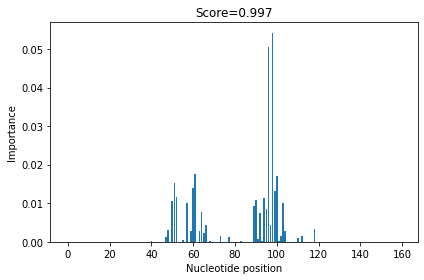

In [3]:
if (fname != "" and seq != "") or (fname == "" and seq == ""):
        print("Error: specify either a sequence or a fasta file")
        exit(1)
        
if os.path.isfile("tmp.fold"):
    os.remove("tmp.fold")

pp = ParameterParser("")
pp.model_file = "models/%s.pmt" % model
if model == "plants":
    pp.seq_len = 320
model = mirDNN(pp)
model.load(pp.model_file)
model.eval()

if seq != "": # return activation per each base
    with open("tmp.fasta", "w") as fout:
        fout.write(">seq_name\n%s\n" % (seq))
    os.system("bin/RNAfold --noPS --infile=tmp.fasta --outfile=tmp.fold")
    fout_name = "mirDNN_nucleotide_importance.png"

if fname != "": # return only scores
    os.system("bin/RNAfold --noPS --infile=%s --outfile=tmp.fold" %fname)
    fout_name = "mirDNN_scores.csv"

dataset = FoldDataset(["tmp.fold"], pp.seq_len)
ind = tr.LongTensor(range(pp.seq_len))

with open("salida.csv", 'w') as csvfile:

    line = "sequence_name,score,"
    if seq != "":
        line += ",".join(["N{0}".format(i) for i in range(pp.seq_len)])
    csvfile.write(line + "\n")

    for i, data in enumerate(tqdm(dataset)):
        x, v, _ = data

        mean = model(x.unsqueeze(0), v.unsqueeze(0)).cpu().detach().item()

        x = x.repeat(pp.seq_len, 1)
        x[ind, ind] = 0
        v = v.repeat(pp.seq_len, 1)

        z = model(x, v).cpu().detach().squeeze()
        z = mean - z
        line = "%s,%.3f," % (dataset.name[i], mean)
        if seq != "":
            line += ",".join(["%.3f" % val for val in z.tolist()])
        csvfile.write(line + "\n")

if fname != "":  # return only scores
    os.rename("salida.csv", fout_name)

if seq != "":  # return image of nucleotide importance
    z[z < 0] = 0
    plt.bar(np.arange(len(z)), z)
    plt.xlabel("Nucleotide position")
    plt.ylabel("Importance")
    plt.title("Score=%.3f" % mean)
    plt.tight_layout()
    #plt.savefig(fout_name)
    plt.show()